# RaGNAR

This notebook demonstrates how to forecast inflation using a **single run of RaGNAR**, as described in the main article. Since RaGNAR relies on an **ensemble of randomly generated networks**, each execution of this notebook produces **slightly different results**. The tables displayed here correspond to a **single run**, whereas those in the main article are based on **averages across 100 runs**.

For **reproducibility**, the forecasts have been saved in the `results/ragnar` directory. Running this notebook from **2010 onwards** can take **several hours**, as ranking the networks each month alone requires a few hours on a single machine. The code for saving and loading results has been **commented out**.

### Notebook Structure
This notebook is organised as follows:

1. **Data:** Load and prepare the dataset.  
2. **Generate Random Networks:** Generate **10,000** random networks and compute the **neighbor sum matrices**.  
3. **Rank Networks:** Rank all networks **each month** using the **one-step-ahead MSE** over the last **30 months**.  
4. **Forecast:** Forecast using the **best-ranked networks**, with various **GNAR model classes** and averaging results across different graphs.  
5. **BIC GNAR:** Compute forecasts by selecting the **best GNAR model** each month using the **BIC criterion**.  
6. **AvGNAR:** Average forecasts across **GNAR models of different orders**.  
7. **Bank of England Comparison:** Compare RaGNAR’s forecasts to those from the **Bank of England**.  
8. **MAPE Evaluation:** Evaluate RaGNAR’s forecasts using **MAPE** instead of **RMSE**.  
9. **Relative RMSEs:** Display all RMSEs **relative to the benchmark** rather than in absolute terms.


### Data

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

In [329]:
# Load the data and calculate the inflation rate
cpi_monthly_data = pd.read_csv("methodology/data/cpi_monthly_data.csv", index_col=0)
cpi_lvl_1 = cpi_monthly_data.iloc[:, :13]
cpi_monthly_data.index = pd.to_datetime(cpi_monthly_data.index)
to_drop = ["04.4", "04.4.1", "04.4.3", "04.5", "04.5.1", "04.5.2", 
           "08.1", "09.2.1/2/3", "10", "10.1/2/5", "10.4", "12.6.2"]
cpi_monthly_data = cpi_monthly_data.iloc[:,:124].drop(columns=to_drop)
cpi_data_pct_12 = cpi_monthly_data.pct_change(12).dropna(how="all").bfill() * 100

# Compute the inflation rate
cpi = cpi_monthly_data[["00"]]
inflation_rate = cpi.pct_change(12).dropna(how="all") * 100
inflation_rate.columns = ["Inflation Rate"]

Year-on-year percentage changes for level 1 CPI components. Figure 1.

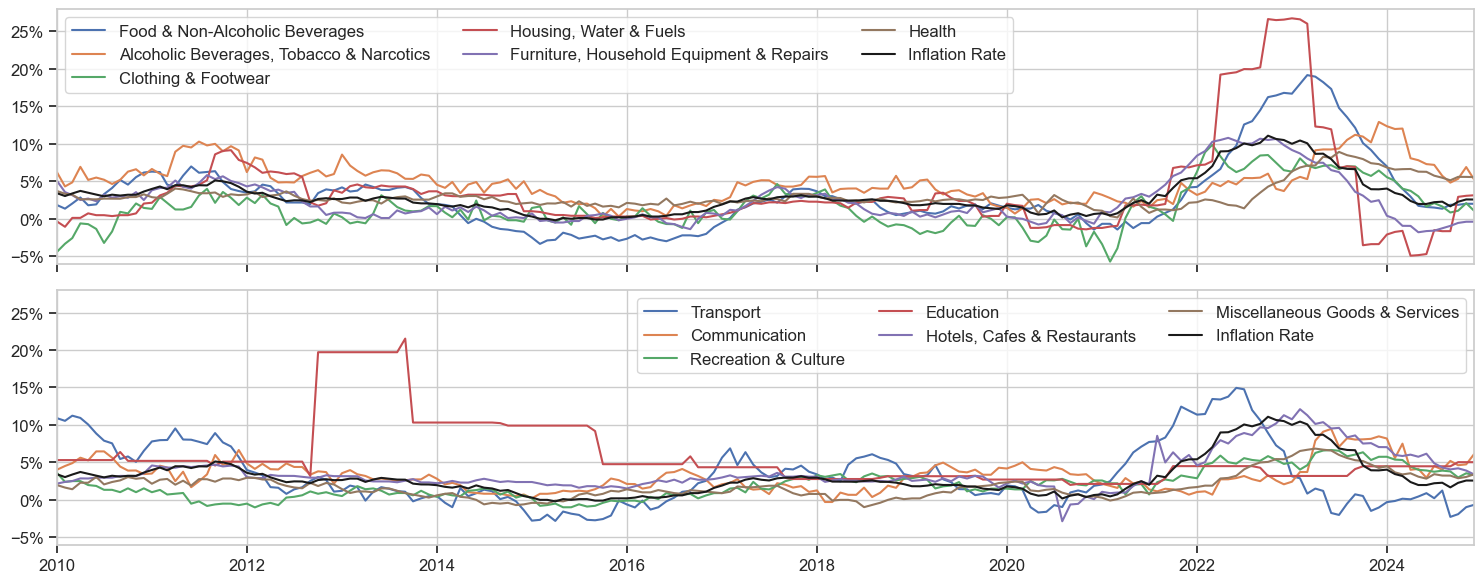

In [336]:
# Creating a 1x3 grid of subplots
cpi_lvl_1_pct = cpi_lvl_1.pct_change(12).dropna(how="all") * 100
cpi_lvl_1_pct.index = pd.to_datetime(cpi_lvl_1_pct.index)
cpi_lvl_1_pct.columns = ["Inflation Rate", "Food & Non-Alcoholic Beverages", "Alcoholic Beverages, Tobacco & Narcotics",
                         "Clothing & Footwear", "Housing, Water & Fuels", "Furniture, Household Equipment & Repairs",
                         "Health", "Transport", "Communication", "Recreation & Culture", "Education", "Hotels, Cafes & Restaurants",
                         "Miscellaneous Goods & Services"]

fig, axs = plt.subplots(2, 1, figsize=(15, 6))

# Manually plotting columns on each subplot
# Adjust the column selection as per your requirement
for i in range(6):
    axs[0].plot(cpi_lvl_1_pct.iloc[:, 1 + i].to_frame(), label=cpi_lvl_1_pct.iloc[:, 1 + i].to_frame().columns[0])
    axs[1].plot(cpi_lvl_1_pct.iloc[:, 7 + i].to_frame(), label=cpi_lvl_1_pct.iloc[:, 7 + i].to_frame().columns[0])

for ax in axs:
    ax.plot(cpi_lvl_1_pct.iloc[:, 0].to_frame(), c="k", label=cpi_lvl_1_pct.iloc[:, 0].to_frame().columns[0])
    ax.set_xlim(pd.to_datetime(["2010-01-01", "2024-12-01"]))
    ax.grid(True)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    ax.set_ylim(-6, 28)

axs[0].set_xticklabels([])
axs[0].set_yticks([-5, 0, 5, 10, 15, 20, 25])
axs[0].legend(fontsize=12, ncol=3, loc="upper left")
axs[1].legend(fontsize=12, ncol=3, loc="upper right")

plt.tight_layout()
plt.show()

### Generate Random Networks

In [220]:
from methodology.random_graphs import generate_erdos_graphs, compute_ns_mats

In [222]:
# Generate 10000 random networks and compute the neighbour_set matrices
adj_mats = generate_erdos_graphs(10000, 112, 0.03)
ns_mats = compute_ns_mats(adj_mats, 2)

The cell below contains the code to **save and load** the adjacency matrices in the `results/ragnar/adj_mats` folder.

In [227]:
# Save in multiple files to be able to push to github
# for i in range(10):
#     np.save(f"results/ragnar/adj_mats/adj_mats_{i + 1}.npy", adj_mats[1000 * i : 1000 * (i + 1)])

# Load the saved files
# adj_mats_list = []
# for i in range(1, 11):
#     adj_mats_list.append(np.load(f"results/ragnar/adj_mats/adj_mats_{i}.npy"))
# adj_mats = np.vstack(adj_mats_list)

### Rank Networks

In [8]:
from methodology.scoring import cpi_rolling_se, cpi_rolling_mse


Construct a dataframe which contains the mse (computed using the last 30 forecasts at the cpi node) for each network, date and model. Total run time for 2009 onwards is just over 2 hours.

In [10]:
# Define the model lags
p_list = [1, 2, 12, 13, 25]
# %%
# Compute the rolling standard errors
se_df = cpi_rolling_se(cpi_data_pct_12, ns_mats, p_list, 2, start_date="2007-07-01", end_date="2024-11-01", n_train=150, n_shift=1) 
# Compute the rolling mean squared errors 
mse_df = cpi_rolling_mse(se_df, 30)

The cell below contains the code to **save and load** the DataFrame containing the **one-step ahead squared errors** in the `results/ragnar/se_df` folder.

In [269]:
# Save in multiple files to be able to push to github
# for i in range(10):
#     se_df.iloc[1000 * i : 1000 * (i + 1), :].to_csv(f"results/ragnar/se_df/se_df_{i+1}.csv")

# Load the saved files
# se_df_list = []
# for i in range(1, 11):
#     se_df_list.append(pd.read_csv(f"results/ragnar/se_df/se_df_{i}.csv", index_col=0, header=[0, 1]))
# se_df_test = pd.concat(se_df_list)
# # Reconstruct the MultiIndex with the dates in the correct format
# se_df_test.columns = pd.MultiIndex.from_arrays([se_df_test.columns.get_level_values(0), 
#                                                 pd.to_datetime(se_df_test.columns.get_level_values(1))])

### Forecast

In [13]:
from methodology.forecasting import forecast_networks, compute_avg_preds, compute_rmse_df

Forecasting using global models is the fastest, taking less than 5 minutes to compute forecasts for the top 5 networks from 2009 onwards. The reason for this comes down to the structure of the design matrix. All parameters are shared across the network, meaning that the number of columns in the design matrix is low.

In [14]:
# Global-alpha model class
glo_preds = forecast_networks(mse_df, cpi_data_pct_12, adj_mats, p_list, 2, model_type="global", n_train=150, n_test=1, start_date="2009-12-01", end_date="2024-12-01", h=12, n_best=5)

In [284]:
# Save the predictions
# glo_preds.to_csv("results/ragnar/global_preds.csv")

# Load the predictions
# glo_preds = pd.read_csv("results/ragnar/global_preds.csv", index_col=0, header=[0, 1, 2])
# glo_preds.columns = pd.MultiIndex.from_tuples([
#     (int(level_0), level_1, int(level_2)) for level_0, level_1, level_2 in glo_preds.columns
# ])
# glo_preds.index = pd.to_datetime(glo_preds.index)

In [105]:
# Forecast from the best network at each time step
glo_avg_1 = compute_avg_preds(glo_preds, 1)
# Forecast by averaging the best 5 networks at each time step
glo_avg_5 = compute_avg_preds(glo_preds, 5)

In this setting, standard models are the slowest to forecast from, with the computation below taking just over 2.5 hours. The reason is again due to the structure of the design matrix. In this case, all parameters need to be estimated jointly, but only some are constrained to be the same across the network, increasing the number of columns of the design matrix significantly.

In [16]:
# Standard model class
std_preds = forecast_networks(mse_df, cpi_data_pct_12, adj_mats, p_list, 2, model_type="standard", n_train=150, n_test=1, start_date="2009-12-01", end_date="2024-12-01", h=12, n_best=5)

In [ ]:
# Save the predictions
# std_preds.to_csv("results/ragnar/standard_preds.csv")

# Load the predictions
# std_preds = pd.read_csv("results/ragnar/standard_preds.csv", index_col=0, header=[0, 1, 2])
# std_preds.columns = pd.MultiIndex.from_tuples([
#     (int(level_0), level_1, int(level_2)) for level_0, level_1, level_2 in std_preds.columns
# ])
# std_preds.index = pd.to_datetime(std_preds.index)

In [106]:
# Forecast from the best network at each time step
std_avg_1 = compute_avg_preds(std_preds, 1)
# Forecast by averaging the best 5 networks at each time step
std_avg_5 = compute_avg_preds(std_preds, 5)

Local GNAR models are also relatively fast, taking just over 15 minutes to forecast inflation for the top 5 networks from 2010 onwards. Similar to global models, the design matrix has relatively few columns. However, unlike global models, local models are fit separately at each node. While this increases computational complexity, the number of rows in each design matrix remains significantly smaller than in global models.

In [17]:
# Local-alphabeta model class
loc_preds = forecast_networks(mse_df, cpi_data_pct_12, adj_mats, p_list, 2, model_type="local", n_train=150, n_test=1, start_date="2009-12-01", end_date="2024-12-01", h=12, n_best=5)

In [ ]:
# Save the predictions
# loc_preds.to_csv("results/ragnar/local_preds.csv")

# Load the predictions
# loc_preds = pd.read_csv("results/ragnar/local_preds.csv", index_col=0, header=[0, 1, 2])
# loc_preds.columns = pd.MultiIndex.from_tuples([
#     (int(level_0), level_1, int(level_2)) for level_0, level_1, level_2 in loc_preds.columns
# ])
# loc_preds.index = pd.to_datetime(loc_preds.index)

In [107]:
# Forecast from the best network at each time step
loc_avg_1 = compute_avg_preds(loc_preds, 1)
# Forecast by averaging the best 5 networks at each time step
loc_avg_5 = compute_avg_preds(loc_preds, 5)

Forecasts computed by averaging across the top 5 networks each month (next 3 cells). Table 11.

In [108]:
np.round(compute_rmse_df(glo_avg_5).T, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
"GNAR(1,1)",0.38,0.57,0.72,0.89,1.07,1.25,1.45,1.64,1.83,1.99,2.14,2.29
"GNAR(1,2)",0.37,0.56,0.72,0.90,1.10,1.30,1.51,1.72,1.93,2.11,2.29,2.46
"GNAR(2,1)",0.37,0.57,0.72,0.89,1.07,1.26,1.47,1.67,1.87,2.05,2.23,2.41
"GNAR(2,2)",0.38,0.58,0.75,0.94,1.14,1.35,1.57,1.80,2.01,2.22,2.42,2.62
"GNAR(12,1)",0.38,0.59,0.76,0.93,1.10,1.29,1.50,1.70,1.90,2.07,2.25,2.43
"GNAR(12,2)",0.35,0.53,0.67,0.83,0.97,1.14,1.33,1.51,1.69,1.85,2.02,2.19
"GNAR(13,1)",0.35,0.54,0.70,0.86,1.02,1.20,1.40,1.61,1.80,1.97,2.15,2.33
"GNAR(13,2)",0.35,0.54,0.70,0.85,1.00,1.17,1.35,1.55,1.75,1.93,2.11,2.31
"GNAR(25,1)",0.37,0.59,0.77,0.94,1.12,1.31,1.54,1.76,1.97,2.16,2.36,2.57
"GNAR(25,2)",0.34,0.54,0.71,0.86,1.02,1.21,1.42,1.64,1.86,2.06,2.26,2.48


In [109]:
np.round(compute_rmse_df(std_avg_5).T, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
"GNAR(1,1)",0.39,0.58,0.72,0.88,1.04,1.21,1.40,1.61,1.80,1.96,2.12,2.31
"GNAR(1,2)",0.37,0.55,0.70,0.86,1.04,1.22,1.42,1.63,1.84,2.02,2.20,2.39
"GNAR(2,1)",0.37,0.55,0.69,0.84,0.99,1.16,1.35,1.53,1.72,1.89,2.04,2.21
"GNAR(2,2)",0.37,0.55,0.69,0.85,1.01,1.20,1.40,1.61,1.82,2.00,2.18,2.37
"GNAR(12,1)",0.39,0.57,0.72,0.89,1.05,1.22,1.41,1.61,1.81,1.97,2.12,2.27
"GNAR(12,2)",0.37,0.54,0.69,0.84,1.00,1.18,1.37,1.56,1.74,1.90,2.04,2.19
"GNAR(13,1)",0.37,0.57,0.74,0.91,1.08,1.26,1.46,1.65,1.85,2.03,2.20,2.39
"GNAR(13,2)",0.37,0.57,0.74,0.91,1.08,1.27,1.47,1.66,1.85,2.02,2.21,2.40
"GNAR(25,1)",0.37,0.58,0.72,0.89,1.06,1.23,1.44,1.65,1.85,2.04,2.21,2.40
"GNAR(25,2)",0.37,0.59,0.74,0.91,1.08,1.25,1.45,1.66,1.85,2.04,2.21,2.40


In [110]:
np.round(compute_rmse_df(loc_avg_5).T, 2)

,1,2,3,4,5,6,7,8,9,10,11,12
"GNAR(1,1)",0.38,0.56,0.68,0.81,0.95,1.09,1.27,1.47,1.65,1.80,1.95,2.14
"GNAR(1,2)",0.36,0.52,0.65,0.76,0.90,1.05,1.21,1.39,1.57,1.72,1.86,2.04
"GNAR(2,1)",0.35,0.55,0.70,0.85,1.01,1.19,1.39,1.59,1.80,1.97,2.14,2.31
"GNAR(2,2)",0.34,0.54,0.68,0.82,0.98,1.15,1.34,1.54,1.74,1.91,2.08,2.27
"GNAR(12,1)",0.35,0.53,0.68,0.85,1.01,1.17,1.36,1.54,1.71,1.87,2.02,2.17
"GNAR(12,2)",0.35,0.55,0.71,0.88,1.04,1.20,1.38,1.56,1.73,1.89,2.04,2.23
"GNAR(13,1)",0.34,0.54,0.70,0.88,1.05,1.23,1.43,1.63,1.82,2.00,2.17,2.36
"GNAR(13,2)",0.34,0.54,0.70,0.88,1.04,1.22,1.41,1.59,1.77,1.94,2.11,2.31
"GNAR(25,1)",0.36,0.57,0.72,0.87,1.02,1.17,1.36,1.52,1.70,1.88,2.06,2.26
"GNAR(25,2)",0.35,0.57,0.71,0.87,1.01,1.16,1.37,1.55,1.73,1.92,2.07,2.30


The network averages are also saved in the results/ragnar folder in the network_avg directory. 

In [293]:
# Save the results
# glo_avg_1.to_csv("results/ragnar/network_avg/global_1.csv")
# glo_avg_5.to_csv("results/ragnar/network_avg/global_5.csv")
# std_avg_1.to_csv("results/ragnar/network_avg/standard_1.csv")
# std_avg_5.to_csv("results/ragnar/network_avg/standard_5.csv")
# loc_avg_1.to_csv("results/ragnar/network_avg/local_1.csv")
# loc_avg_5.to_csv("results/ragnar/network_avg/local_5.csv")

# Function to load the results in this format (two headers, where the first is the model and
# the second is the forecast horizon)
def load_results(path):
    results = pd.read_csv(path, index_col=0, header=[0, 1])
    results.columns = pd.MultiIndex.from_tuples([
        (level_0, int(level_1)) for level_0, level_1 in results.columns
    ])
    results.index = pd.to_datetime(results.index)
    return results

### BIC GNAR

This section forecasts inflation each month using the best GNAR model according to the BIC. The forecasts are saved in results/ragnar/bic.

In [22]:
from methodology.bic_gnar import select_bic_model_order, bic_forecasts

In [217]:
bic_1 = select_bic_model_order(mse_df[[f"GNAR({p},1)" for p in p_list]], 30)
bic_2 = select_bic_model_order(mse_df[[f"GNAR({p},2)" for p in p_list]], 30)
bic_s = select_bic_model_order(mse_df, 30)

Plot displaying the BIC model orders. Figure 3.

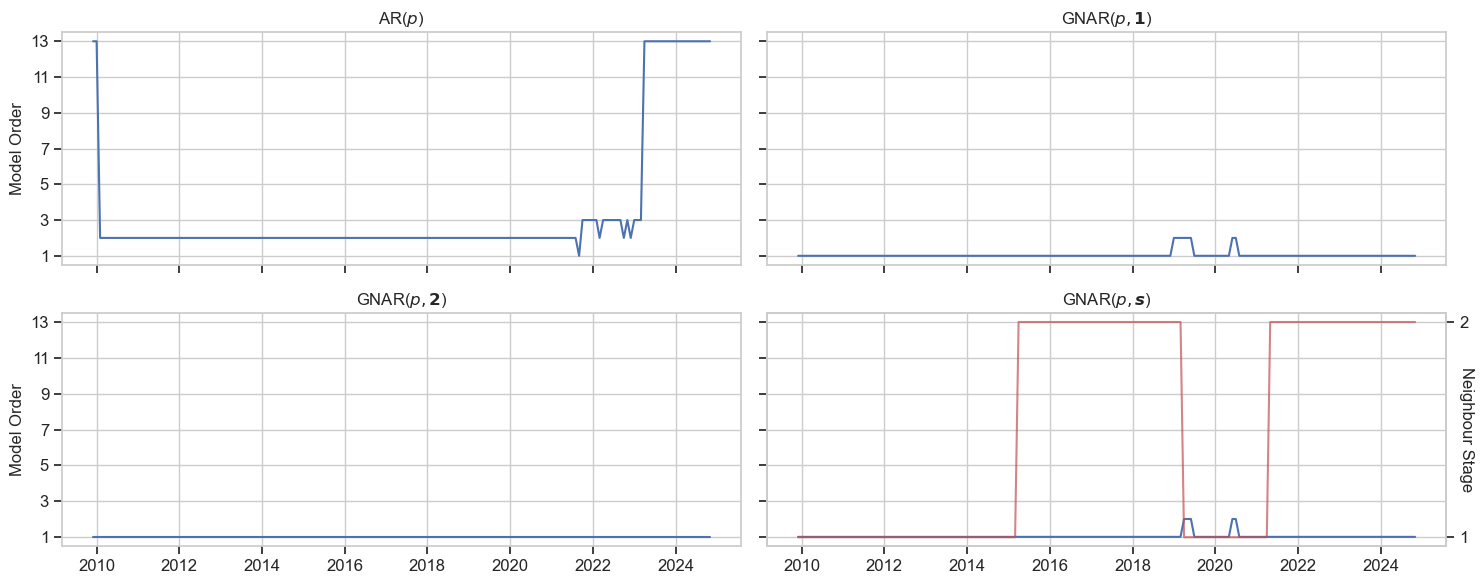

In [324]:
from methodology.ar_forecasts import rolling_bic_ar_forecast
bic_ar, bic_p = rolling_bic_ar_forecast(inflation_rate, 240, 12, "2009-12-01", "2024-11-01")

fig,axes = plt.subplots(2, 2, figsize=(15, 6))
axes[0, 0].plot(bic_glo_1.index, bic_p)
axes[0, 0].set_ylim(0.5, 13.5)
axes[0, 0].set_yticks(range(1,14,2))
axes[0, 0].set_title(r"AR($p$)")
axes[0, 0].set_xticklabels([])
axes[0, 0].set_ylabel("Model Order")

axes[0, 1].plot(bic_glo_1.index, extract_order(bic_1))
axes[0, 1].set_ylim(0.5, 13.5)
axes[0, 1].set_yticks(range(1,14,2))
axes[0, 1].set_yticklabels([])
axes[0, 1].set_title(r"GNAR($p, \boldsymbol{1}$)")
axes[0, 1].set_xticklabels([])

axes[1, 0].plot(bic_glo_1.index, extract_order(bic_2))
axes[1, 0].set_ylim(0.5, 13.5)
axes[1, 0].set_yticks(range(1,14,2))
axes[1, 0].set_title(r"GNAR($p, \boldsymbol{2}$)")
axes[1, 0].set_ylabel("Model Order")

axes[1, 1].plot(bic_glo_1.index, extract_order(bic_s))
axes[1, 1].set_ylim(0.5, 13.5)
axes[1, 1].set_yticks(range(1,14,2))
axes[1, 1].set_yticklabels([])
axes[1, 1].set_title(r"GNAR($p, \boldsymbol{s}$)")
ax = axes[1, 1].twinx()
ax.plot(bic_glo_1.index, extract_neighbour_stage(bic_s), c="r", alpha=0.7)
ax.set_ylim(0.96, 2.04)
ax.set_yticks([1, 2])
ax.grid(False)
ax.set_ylabel("Neighbour Stage", rotation=-90)

plt.tight_layout()

In [125]:
bic_glo_1 = pd.concat([bic_forecasts(glo_avg_1, bic_1, "GNAR(p,1)"), bic_forecasts(glo_avg_1, bic_2, "GNAR(p,2)"), 
                       bic_forecasts(glo_avg_1, bic_s, "GNAR(p,s)")], axis=1)
bic_glo_5 = pd.concat([bic_forecasts(glo_avg_5, bic_1, "GNAR(p,1)"), bic_forecasts(glo_avg_5, bic_2, "GNAR(p,2)"), 
                       bic_forecasts(glo_avg_5, bic_s, "GNAR(p,s)")], axis=1)
bic_std_1 = pd.concat([bic_forecasts(std_avg_1, bic_1, "GNAR(p,1)"), bic_forecasts(std_avg_1, bic_2, "GNAR(p,2)"), 
                       bic_forecasts(std_avg_1, bic_s, "GNAR(p,s)")], axis=1)
bic_std_5 = pd.concat([bic_forecasts(std_avg_5, bic_1, "GNAR(p,1)"), bic_forecasts(std_avg_5, bic_2, "GNAR(p,2)"), 
                       bic_forecasts(std_avg_5, bic_s, "GNAR(p,s)")], axis=1)
bic_loc_1 = pd.concat([bic_forecasts(loc_avg_1, bic_1, "GNAR(p,1)"), bic_forecasts(loc_avg_1, bic_2, "GNAR(p,2)"), 
                       bic_forecasts(loc_avg_1, bic_s, "GNAR(p,s)")], axis=1)
bic_loc_5 = pd.concat([bic_forecasts(loc_avg_5, bic_1, "GNAR(p,1)"), bic_forecasts(loc_avg_5, bic_2, "GNAR(p,2)"), 
                       bic_forecasts(loc_avg_5, bic_s, "GNAR(p,s)")], axis=1)

Forecasts using only the best network each month. Part of Table 8.

In [126]:
np.round(pd.concat([compute_rmse_df(bic_glo_1).T, compute_rmse_df(bic_std_1).T, 
                    compute_rmse_df(bic_loc_1).T], keys=["Global", "Standard", "Local"]), 2)

1     2     3     4     5     6     7     8     9   \
Global   GNAR(p,1)  0.38  0.58  0.76  0.93  1.11  1.30  1.51  1.69  1.87   
         GNAR(p,2)  0.39  0.58  0.76  0.95  1.15  1.35  1.58  1.79  1.99   
         GNAR(p,s)  0.39  0.58  0.76  0.96  1.16  1.37  1.59  1.80  2.01   
Standard GNAR(p,1)  0.41  0.62  0.78  0.95  1.12  1.31  1.52  1.74  1.94   
         GNAR(p,2)  0.39  0.58  0.76  0.92  1.09  1.30  1.49  1.69  1.89   
         GNAR(p,s)  0.39  0.59  0.76  0.92  1.10  1.30  1.49  1.70  1.90   
Local    GNAR(p,1)  0.39  0.57  0.70  0.84  0.98  1.13  1.32  1.53  1.72   
         GNAR(p,2)  0.37  0.54  0.66  0.77  0.91  1.08  1.25  1.44  1.64   
         GNAR(p,s)  0.38  0.54  0.66  0.77  0.91  1.07  1.24  1.44  1.64   

                      10    11    12  
Global   GNAR(p,1)  2.03  2.18  2.32  
         GNAR(p,2)  2.18  2.36  2.53  
         GNAR(p,s)  2.19  2.37  2.54  
Standard GNAR(p,1)  2.10  2.25  2.47  
         GNAR(p,2)  2.06  2.21  2.42  
         GNAR(p,s)  2.06  2.22  2.43  
Local    GNAR(p,1)  1.87  2.02  2.22  
         GNAR(p,2)  1.81  1.97  2.17  
         GNAR(p,s)  1.81  1.97  2.18

Forecasts computed by averaging across the 5 best networks each month. Part of Table 9.

In [127]:
np.round(pd.concat([compute_rmse_df(bic_glo_5).T, compute_rmse_df(bic_std_5).T, 
                    compute_rmse_df(bic_loc_5).T], keys=["Global", "Standard", "Local"]), 2)

1     2     3     4     5     6     7     8     9   \
Global   GNAR(p,1)  0.38  0.57  0.72  0.89  1.07  1.25  1.45  1.64  1.83   
         GNAR(p,2)  0.37  0.56  0.72  0.90  1.10  1.30  1.51  1.72  1.93   
         GNAR(p,s)  0.38  0.57  0.73  0.92  1.11  1.31  1.52  1.74  1.95   
Standard GNAR(p,1)  0.39  0.58  0.72  0.88  1.04  1.21  1.40  1.61  1.80   
         GNAR(p,2)  0.37  0.55  0.70  0.86  1.04  1.22  1.42  1.63  1.84   
         GNAR(p,s)  0.38  0.56  0.71  0.87  1.05  1.23  1.44  1.64  1.85   
Local    GNAR(p,1)  0.38  0.56  0.68  0.81  0.95  1.09  1.27  1.47  1.65   
         GNAR(p,2)  0.36  0.52  0.65  0.76  0.90  1.05  1.21  1.39  1.57   
         GNAR(p,s)  0.36  0.53  0.65  0.76  0.90  1.04  1.21  1.38  1.56   

                      10    11    12  
Global   GNAR(p,1)  1.99  2.14  2.29  
         GNAR(p,2)  2.11  2.29  2.46  
         GNAR(p,s)  2.13  2.30  2.47  
Standard GNAR(p,1)  1.96  2.12  2.31  
         GNAR(p,2)  2.02  2.20  2.39  
         GNAR(p,s)  2.04  2.22  2.41  
Local    GNAR(p,1)  1.80  1.95  2.14  
         GNAR(p,2)  1.72  1.86  2.04  
         GNAR(p,s)  1.71  1.85  2.03

In [156]:
# Save the results
# bic_glo_1.to_csv("results/ragnar/bic/global_1.csv")
# bic_glo_5.to_csv("results/ragnar/bic/global_5.csv")
# bic_std_1.to_csv("results/ragnar/bic/standard_1.csv")
# bic_std_5.to_csv("results/ragnar/bic/standard_5.csv")
# bic_loc_1.to_csv("results/ragnar/bic/local_1.csv")
# bic_loc_5.to_csv("results/ragnar/bic/local_5.csv")

# To load the results use the load_results function defined above. For example
# bic_glo_1 = load_results("results/ragnar/bic/global_1.csv")

### AvGNAR

Here forecasts are constructed by averaging GNAR processes of different orders. The results are saved in results/ragnar/avgnar.

In [74]:
from methodology.forecasting import avgnar

In [128]:
dates = glo_avg_5.index
avgnar_models = ["AvGNAR({1,13,25},{1})", "AvGNAR({2,13,25},{1})", "AvGNAR({1,13,25},{2})", 
                 "AvGNAR({2,13,25},{2})", "AvGNAR({1,13,25},{1,2})", "AvGNAR({2,13,25},{1,2})"]
avgnar_columns = pd.MultiIndex.from_product([avgnar_models, range(1, 13)])
avgnar_glo_1 = pd.DataFrame(index=dates, columns=avgnar_columns, dtype=float)
avgnar_glo_5 = pd.DataFrame(index=dates, columns=avgnar_columns, dtype=float)
avgnar_std_1 = pd.DataFrame(index=dates, columns=avgnar_columns, dtype=float)
avgnar_std_5 = pd.DataFrame(index=dates, columns=avgnar_columns, dtype=float)
avgnar_loc_1 = pd.DataFrame(index=dates, columns=avgnar_columns, dtype=float)
avgnar_loc_5 = pd.DataFrame(index=dates, columns=avgnar_columns, dtype=float)

In [129]:
avg_dfs = [glo_avg_1, glo_avg_5, std_avg_1, std_avg_5, loc_avg_1, loc_avg_5]
avgnar_dfs = [avgnar_glo_1, avgnar_glo_5, avgnar_std_1, avgnar_std_5, avgnar_loc_1, avgnar_loc_5]
for df1,df2 in zip(avg_dfs, avgnar_dfs):
    df2.loc[:, "AvGNAR({1,13,25},{1})"] = avgnar(df1, [1, 13, 25], [1]).to_numpy()
    df2.loc[:, "AvGNAR({2,13,25},{1})"] = avgnar(df1, [2, 13, 25], [1]).to_numpy()
    df2.loc[:, "AvGNAR({1,13,25},{2})"] = avgnar(df1, [1, 13, 25], [2]).to_numpy()
    df2.loc[:, "AvGNAR({2,13,25},{2})"] = avgnar(df1, [2, 13, 25], [2]).to_numpy()
    df2.loc[:, "AvGNAR({1,13,25},{1,2})"] = avgnar(df1, [1, 13, 25], [1, 2]).to_numpy()
    df2.loc[:, "AvGNAR({2,13,25},{1,2})"] = avgnar(df1, [2, 13, 25], [1, 2]).to_numpy()

Forecasts using only the best network each month. Part of Table 8.

In [130]:
np.round(pd.concat([compute_rmse_df(avgnar_glo_1).T, compute_rmse_df(avgnar_std_1).T, 
                    compute_rmse_df(avgnar_loc_1).T], keys=["Global", "Standard", "Local"]), 2)

1     2     3     4     5     6     7   \
Global   AvGNAR({1,13,25},{1})    0.36  0.54  0.71  0.86  1.02  1.20  1.40   
         AvGNAR({2,13,25},{1})    0.36  0.54  0.70  0.85  1.01  1.18  1.37   
         AvGNAR({1,13,25},{2})    0.34  0.54  0.70  0.84  1.00  1.18  1.35   
         AvGNAR({2,13,25},{2})    0.34  0.54  0.69  0.83  0.99  1.16  1.33   
         AvGNAR({1,13,25},{1,2})  0.34  0.53  0.69  0.84  1.00  1.18  1.36   
         AvGNAR({2,13,25},{1,2})  0.34  0.53  0.68  0.83  0.99  1.16  1.34   
Standard AvGNAR({1,13,25},{1})    0.35  0.54  0.69  0.84  1.01  1.18  1.37   
         AvGNAR({2,13,25},{1})    0.35  0.53  0.68  0.84  1.00  1.17  1.35   
         AvGNAR({1,13,25},{2})    0.34  0.53  0.68  0.83  0.99  1.17  1.35   
         AvGNAR({2,13,25},{2})    0.34  0.52  0.67  0.81  0.98  1.16  1.33   
         AvGNAR({1,13,25},{1,2})  0.34  0.53  0.68  0.83  0.99  1.17  1.35   
         AvGNAR({2,13,25},{1,2})  0.34  0.52  0.67  0.82  0.98  1.15  1.33   
Local    AvGNAR({1,13,25},{1})    0.34  0.53  0.67  0.83  0.98  1.15  1.34   
         AvGNAR({2,13,25},{1})    0.34  0.53  0.68  0.84  1.00  1.17  1.36   
         AvGNAR({1,13,25},{2})    0.34  0.54  0.66  0.78  0.92  1.09  1.28   
         AvGNAR({2,13,25},{2})    0.33  0.55  0.67  0.81  0.95  1.12  1.32   
         AvGNAR({1,13,25},{1,2})  0.33  0.52  0.64  0.78  0.92  1.09  1.28   
         AvGNAR({2,13,25},{1,2})  0.33  0.53  0.66  0.80  0.94  1.11  1.30   

                                    8     9     10    11    12  
Global   AvGNAR({1,13,25},{1})    1.58  1.76  1.92  2.09  2.27  
         AvGNAR({2,13,25},{1})    1.56  1.74  1.90  2.07  2.25  
         AvGNAR({1,13,25},{2})    1.54  1.73  1.90  2.09  2.27  
         AvGNAR({2,13,25},{2})    1.51  1.70  1.88  2.06  2.25  
         AvGNAR({1,13,25},{1,2})  1.54  1.73  1.90  2.08  2.26  
         AvGNAR({2,13,25},{1,2})  1.52  1.71  1.88  2.05  2.24  
Standard AvGNAR({1,13,25},{1})    1.56  1.75  1.93  2.10  2.28  
         AvGNAR({2,13,25},{1})    1.54  1.73  1.92  2.08  2.26  
         AvGNAR({1,13,25},{2})    1.53  1.70  1.88  2.05  2.24  
         AvGNAR({2,13,25},{2})    1.52  1.70  1.88  2.06  2.25  
         AvGNAR({1,13,25},{1,2})  1.53  1.72  1.89  2.06  2.25  
         AvGNAR({2,13,25},{1,2})  1.52  1.71  1.89  2.06  2.24  
Local    AvGNAR({1,13,25},{1})    1.53  1.71  1.88  2.04  2.22  
         AvGNAR({2,13,25},{1})    1.55  1.73  1.91  2.07  2.25  
         AvGNAR({1,13,25},{2})    1.49  1.69  1.87  2.05  2.28  
         AvGNAR({2,13,25},{2})    1.53  1.74  1.92  2.11  2.34  
         AvGNAR({1,13,25},{1,2})  1.48  1.66  1.83  2.00  2.20  
         AvGNAR({2,13,25},{1,2})  1.50  1.69  1.87  2.04  2.24

Forecasts computed by averaging across the 5 best networks each month. Part of Table 9.

In [131]:
np.round(pd.concat([compute_rmse_df(avgnar_glo_5).T, compute_rmse_df(avgnar_std_5).T, 
                    compute_rmse_df(avgnar_loc_5).T], keys=["Global", "Standard", "Local"]), 2)

1     2     3     4     5     6     7   \
Global   AvGNAR({1,13,25},{1})    0.35  0.54  0.69  0.85  1.01  1.19  1.38   
         AvGNAR({2,13,25},{1})    0.35  0.53  0.69  0.84  0.99  1.17  1.36   
         AvGNAR({1,13,25},{2})    0.33  0.50  0.65  0.79  0.93  1.09  1.28   
         AvGNAR({2,13,25},{2})    0.33  0.51  0.65  0.79  0.93  1.10  1.28   
         AvGNAR({1,13,25},{1,2})  0.34  0.52  0.66  0.81  0.96  1.13  1.32   
         AvGNAR({2,13,25},{1,2})  0.34  0.52  0.66  0.81  0.96  1.13  1.32   
Standard AvGNAR({1,13,25},{1})    0.35  0.53  0.67  0.82  0.98  1.14  1.33   
         AvGNAR({2,13,25},{1})    0.35  0.53  0.67  0.83  0.98  1.15  1.33   
         AvGNAR({1,13,25},{2})    0.34  0.52  0.66  0.82  0.97  1.14  1.33   
         AvGNAR({2,13,25},{2})    0.34  0.52  0.66  0.82  0.98  1.15  1.34   
         AvGNAR({1,13,25},{1,2})  0.34  0.52  0.66  0.82  0.97  1.14  1.32   
         AvGNAR({2,13,25},{1,2})  0.35  0.53  0.67  0.82  0.97  1.14  1.33   
Local    AvGNAR({1,13,25},{1})    0.32  0.50  0.63  0.77  0.92  1.08  1.26   
         AvGNAR({2,13,25},{1})    0.32  0.50  0.64  0.79  0.94  1.10  1.29   
         AvGNAR({1,13,25},{2})    0.31  0.49  0.62  0.76  0.90  1.06  1.24   
         AvGNAR({2,13,25},{2})    0.31  0.50  0.63  0.78  0.93  1.09  1.28   
         AvGNAR({1,13,25},{1,2})  0.31  0.49  0.62  0.76  0.90  1.06  1.24   
         AvGNAR({2,13,25},{1,2})  0.31  0.50  0.63  0.78  0.93  1.09  1.28   

                                    8     9     10    11    12  
Global   AvGNAR({1,13,25},{1})    1.58  1.76  1.93  2.09  2.27  
         AvGNAR({2,13,25},{1})    1.56  1.74  1.91  2.07  2.25  
         AvGNAR({1,13,25},{2})    1.46  1.65  1.83  2.00  2.19  
         AvGNAR({2,13,25},{2})    1.47  1.65  1.83  2.00  2.19  
         AvGNAR({1,13,25},{1,2})  1.51  1.70  1.87  2.04  2.22  
         AvGNAR({2,13,25},{1,2})  1.51  1.69  1.86  2.03  2.21  
Standard AvGNAR({1,13,25},{1})    1.52  1.70  1.87  2.03  2.21  
         AvGNAR({2,13,25},{1})    1.52  1.70  1.87  2.04  2.21  
         AvGNAR({1,13,25},{2})    1.51  1.69  1.87  2.04  2.23  
         AvGNAR({2,13,25},{2})    1.53  1.71  1.89  2.06  2.24  
         AvGNAR({1,13,25},{1,2})  1.51  1.69  1.87  2.03  2.22  
         AvGNAR({2,13,25},{1,2})  1.52  1.70  1.88  2.04  2.22  
Local    AvGNAR({1,13,25},{1})    1.44  1.62  1.79  1.96  2.15  
         AvGNAR({2,13,25},{1})    1.48  1.66  1.84  2.01  2.19  
         AvGNAR({1,13,25},{2})    1.43  1.61  1.78  1.93  2.12  
         AvGNAR({2,13,25},{2})    1.47  1.65  1.83  1.99  2.18  
         AvGNAR({1,13,25},{1,2})  1.43  1.60  1.78  1.94  2.13  
         AvGNAR({2,13,25},{1,2})  1.46  1.65  1.82  1.99  2.18

In [169]:
from methodology.plotting import create_grid_of_plots

Some RaGNAR forecasts. Figure 4.

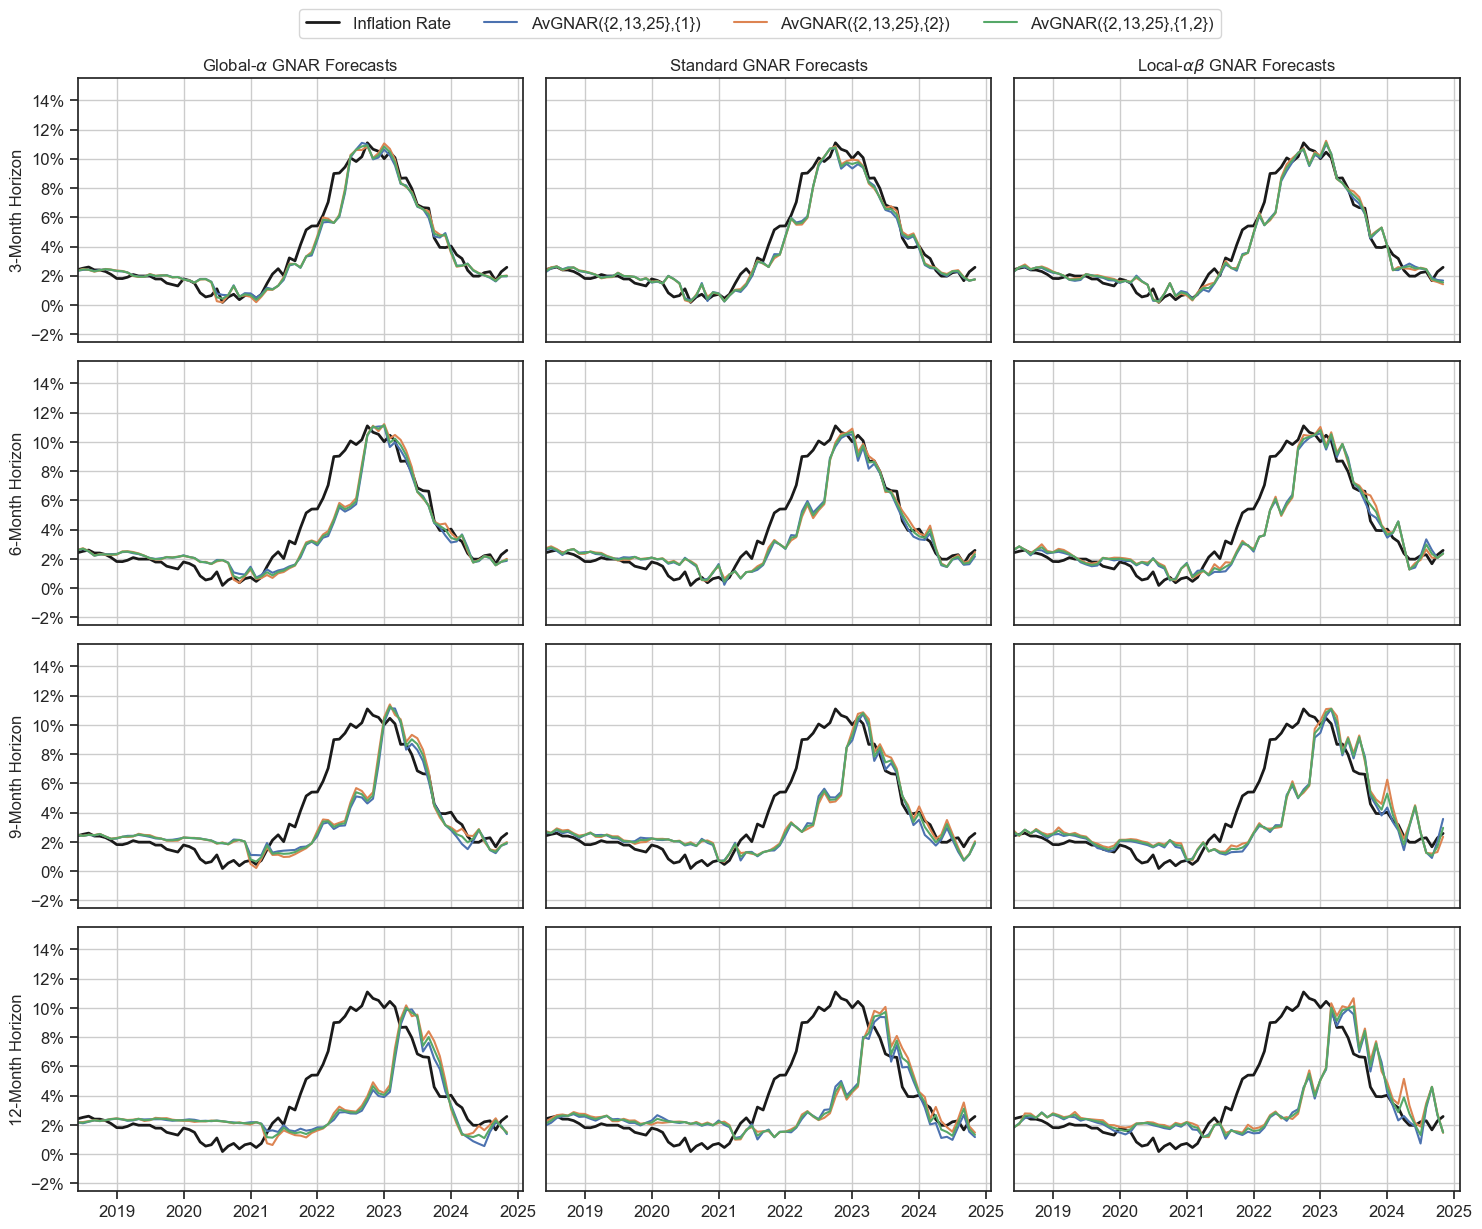

In [193]:
create_grid_of_plots([avgnar_glo_5, avgnar_std_5, avgnar_loc_5], [3, 6, 9, 12], "2018-06-01", "2024-11-01", [avgnar_models[i] for i in [1, 3, 5]], save=True, name="figures/forecasts.png")

In [157]:
# Save the results
# avgnar_glo_1.to_csv("results/ragnar/avgnar/global_1.csv")
# avgnar_glo_5.to_csv("results/ragnar/avgnar/global_5.csv")
# avgnar_std_1.to_csv("results/ragnar/avgnar/standard_1.csv")
# avgnar_std_5.to_csv("results/ragnar/avgnar/standard_5.csv")
# avgnar_loc_1.to_csv("results/ragnar/avgnar/local_1.csv")
# avgnar_loc_5.to_csv("results/ragnar/avgnar/local_5.csv")

# To load the results use the load_results function defined above. For example
# avgnar_glo_1 = load_results("results/ragnar/avgnar/global_1.csv")

### Bank of England

In [122]:
from methodology.bank_of_england import rmse_vs_bank

Comparison to the Bank of England in terms of RMSE (next two cells). Table 5.

In [146]:
bic_glo_bank_rmse = np.round(rmse_vs_bank(bic_glo_5), 2)
bic_std_bank_rmse = np.round(rmse_vs_bank(bic_std_5), 2)
bic_loc_bank_rmse = np.round(rmse_vs_bank(bic_loc_5), 2)
pd.concat([bic_glo_bank_rmse[["Bank of England"]].T, bic_glo_bank_rmse.drop(columns=["Bank of England"]).T,
           bic_std_bank_rmse.drop(columns=["Bank of England"]).T, bic_loc_bank_rmse.drop(columns=["Bank of England"]).T],
           keys=["", "Global", "Standard", "Local"])

1     2     3     4     5     6
         Bank of England  0.17  0.32  0.48  0.85  0.93  0.92
Global   GNAR(p,1)        0.68  0.85  0.92  0.82  0.92  0.91
         GNAR(p,2)        0.72  0.86  0.92  1.40  1.54  1.63
         GNAR(p,s)        0.72  0.87  0.92  1.40  1.54  1.63
Standard GNAR(p,1)        0.70  0.84  0.93  0.88  0.94  0.93
         GNAR(p,2)        0.72  0.85  0.90  1.09  1.22  1.26
         GNAR(p,s)        0.72  0.85  0.90  1.09  1.22  1.26
Local    GNAR(p,1)        0.71  0.82  0.89  0.76  0.79  0.71
         GNAR(p,2)        0.67  0.78  0.82  0.66  0.76  0.66
         GNAR(p,s)        0.68  0.79  0.82  0.66  0.76  0.66

In [147]:
avgnar_glo_bank_rmse = np.round(rmse_vs_bank(avgnar_glo_5), 2)
avgnar_std_bank_rmse = np.round(rmse_vs_bank(avgnar_std_5), 2)
avgnar_loc_bank_rmse = np.round(rmse_vs_bank(avgnar_loc_5), 2)
pd.concat([avgnar_glo_bank_rmse[["Bank of England"]].T, avgnar_glo_bank_rmse.drop(columns=["Bank of England"]).T,
           avgnar_std_bank_rmse.drop(columns=["Bank of England"]).T, avgnar_loc_bank_rmse.drop(columns=["Bank of England"]).T],
           keys=["", "Global", "Standard", "Local"])

1     2     3     4     5     6
         Bank of England          0.17  0.32  0.48  0.85  0.93  0.92
Global   AvGNAR({1,13,25},{1,2})  0.61  0.76  0.88  0.25  0.47  0.57
         AvGNAR({1,13,25},{1})    0.61  0.76  0.87  0.25  0.41  0.51
         AvGNAR({1,13,25},{2})    0.60  0.68  0.72  0.42  0.46  0.51
         AvGNAR({2,13,25},{1,2})  0.61  0.69  0.74  0.43  0.43  0.48
         AvGNAR({2,13,25},{1})    0.60  0.71  0.79  0.28  0.40  0.49
         AvGNAR({2,13,25},{2})    0.61  0.72  0.80  0.31  0.37  0.45
Standard AvGNAR({1,13,25},{1,2})  0.63  0.76  0.82  0.37  0.39  0.37
         AvGNAR({1,13,25},{1})    0.62  0.76  0.82  0.39  0.44  0.48
         AvGNAR({1,13,25},{2})    0.63  0.77  0.81  0.56  0.54  0.49
         AvGNAR({2,13,25},{1,2})  0.63  0.77  0.81  0.52  0.51  0.48
         AvGNAR({2,13,25},{1})    0.63  0.76  0.81  0.44  0.44  0.39
         AvGNAR({2,13,25},{2})    0.62  0.76  0.81  0.44  0.45  0.45
Local    AvGNAR({1,13,25},{1,2})  0.57  0.72  0.79  0.57  0.49  0.60
         AvGNAR({1,13,25},{1})    0.54  0.72  0.78  0.66  0.60  0.73
         AvGNAR({1,13,25},{2})    0.54  0.68  0.73  0.54  0.46  0.50
         AvGNAR({2,13,25},{1,2})  0.52  0.69  0.75  0.64  0.56  0.60
         AvGNAR({2,13,25},{1})    0.56  0.70  0.76  0.54  0.46  0.54
         AvGNAR({2,13,25},{2})    0.53  0.70  0.76  0.64  0.56  0.65

### MAPE

In [149]:
from methodology.forecasting import compute_mape_df
from methodology.bank_of_england import mape_vs_bank

Performance in terms of MAPE over the whole sample period (next two cells). Table 6.

In [150]:
np.round(pd.concat([compute_mape_df(bic_glo_5).T, compute_mape_df(bic_std_5).T, 
                    compute_mape_df(bic_loc_5).T], keys=["Global", "Standard", "Local"]), 2)

1      2      3      4      5      6      7      8   \
Global   GNAR(p,1)  9.10  13.85  17.27  21.84  26.38  29.96  33.90  37.45   
         GNAR(p,2)  8.76  12.83  15.92  20.66  25.18  28.94  33.16  37.05   
         GNAR(p,s)  8.97  13.46  16.86  21.71  26.54  30.38  34.68  38.68   
Standard GNAR(p,1)  8.67  12.35  14.79  18.35  21.87  24.39  28.13  31.61   
         GNAR(p,2)  8.35  11.81  14.17  17.83  21.65  24.70  28.62  32.08   
         GNAR(p,s)  8.54  12.05  14.50  18.30  22.34  25.23  29.44  33.13   
Local    GNAR(p,1)  8.35  11.67  13.73  16.88  20.18  21.86  25.37  28.58   
         GNAR(p,2)  7.99  10.91  13.06  15.98  19.47  22.25  25.58  28.57   
         GNAR(p,s)  8.24  11.16  13.12  16.36  19.88  21.80  25.47  28.43   

                       9      10     11     12  
Global   GNAR(p,1)  40.72  43.87  46.86  49.40  
         GNAR(p,2)  40.62  44.29  47.76  50.85  
         GNAR(p,s)  42.37  46.04  49.58  52.64  
Standard GNAR(p,1)  34.76  37.93  41.57  45.15  
         GNAR(p,2)  35.75  39.40  43.31  46.96  
         GNAR(p,s)  36.62  40.26  44.38  48.15  
Local    GNAR(p,1)  31.31  34.18  37.61  40.90  
         GNAR(p,2)  31.51  34.61  37.86  40.81  
         GNAR(p,s)  31.19  34.14  37.53  40.34

In [151]:
np.round(pd.concat([compute_mape_df(avgnar_glo_5).T, compute_mape_df(avgnar_std_5).T, 
                    compute_mape_df(avgnar_loc_5).T], keys=["Global", "Standard", "Local"]), 2)

1      2      3      4      5      6   \
Global   AvGNAR({1,13,25},{1})    8.28  12.42  15.69  19.38  23.40  27.03   
         AvGNAR({2,13,25},{1})    8.22  12.14  15.19  18.79  22.71  26.36   
         AvGNAR({1,13,25},{2})    7.87  11.50  14.12  17.42  21.08  23.85   
         AvGNAR({2,13,25},{2})    7.86  11.41  13.91  17.12  20.55  23.41   
         AvGNAR({1,13,25},{1,2})  8.05  11.83  14.70  18.21  22.00  25.17   
         AvGNAR({2,13,25},{1,2})  8.00  11.59  14.48  17.77  21.39  24.61   
Standard AvGNAR({1,13,25},{1})    8.01  11.84  14.21  17.70  21.60  24.86   
         AvGNAR({2,13,25},{1})    8.06  11.99  14.37  17.88  22.07  25.55   
         AvGNAR({1,13,25},{2})    7.69  11.45  13.56  16.85  20.74  24.06   
         AvGNAR({2,13,25},{2})    7.72  11.56  13.65  17.03  21.04  24.49   
         AvGNAR({1,13,25},{1,2})  7.83  11.62  13.78  17.20  21.09  24.26   
         AvGNAR({2,13,25},{1,2})  7.87  11.75  13.94  17.39  21.51  24.78   
Local    AvGNAR({1,13,25},{1})    7.32  11.20  13.82  17.31  20.84  23.81   
         AvGNAR({2,13,25},{1})    7.35  11.45  14.13  17.52  21.68  25.23   
         AvGNAR({1,13,25},{2})    7.16  10.80  12.82  15.79  19.21  22.17   
         AvGNAR({2,13,25},{2})    7.25  11.11  13.11  16.33  20.01  23.13   
         AvGNAR({1,13,25},{1,2})  7.13  10.96  13.22  16.37  19.86  22.82   
         AvGNAR({2,13,25},{1,2})  7.19  11.24  13.52  16.75  20.67  24.11   

                                     7      8      9      10     11     12  
Global   AvGNAR({1,13,25},{1})    31.08  34.91  38.19  41.44  44.88  48.27  
         AvGNAR({2,13,25},{1})    30.42  34.21  37.53  40.84  44.35  47.78  
         AvGNAR({1,13,25},{2})    27.54  31.39  34.60  37.97  41.72  45.50  
         AvGNAR({2,13,25},{2})    27.10  30.97  34.08  37.52  41.38  45.32  
         AvGNAR({1,13,25},{1,2})  29.05  32.92  36.09  39.37  43.04  46.65  
         AvGNAR({2,13,25},{1,2})  28.52  32.37  35.52  38.86  42.60  46.35  
Standard AvGNAR({1,13,25},{1})    29.01  33.25  36.46  39.94  43.70  47.54  
         AvGNAR({2,13,25},{1})    29.67  33.86  37.28  40.50  44.29  48.07  
         AvGNAR({1,13,25},{2})    27.64  31.63  34.90  38.51  42.34  46.03  
         AvGNAR({2,13,25},{2})    28.14  32.20  35.55  39.04  42.85  46.58  
         AvGNAR({1,13,25},{1,2})  28.13  32.27  35.56  39.00  42.70  46.46  
         AvGNAR({2,13,25},{1,2})  28.72  32.86  36.32  39.53  43.31  47.09  
Local    AvGNAR({1,13,25},{1})    27.14  30.90  33.74  36.79  40.67  44.56  
         AvGNAR({2,13,25},{1})    28.52  32.35  35.55  38.56  42.34  46.31  
         AvGNAR({1,13,25},{2})    25.62  29.25  32.29  35.28  39.25  42.98  
         AvGNAR({2,13,25},{2})    26.63  30.58  33.84  36.89  40.76  44.74  
         AvGNAR({1,13,25},{1,2})  26.08  29.76  32.71  35.63  39.47  43.30  
         AvGNAR({2,13,25},{1,2})  27.37  31.28  34.47  37.47  41.23  45.17

Comparison to the Bank of England in terms of MAPE (next two cells). Table 7.

In [152]:
bic_glo_bank_mape = np.round(mape_vs_bank(bic_glo_5), 2)
bic_std_bank_mape = np.round(mape_vs_bank(bic_std_5), 2)
bic_loc_bank_mape = np.round(mape_vs_bank(bic_loc_5), 2)
pd.concat([bic_glo_bank_mape[["Bank of England"]].T, bic_glo_bank_mape.drop(columns=["Bank of England"]).T,
           bic_std_bank_mape.drop(columns=["Bank of England"]).T, bic_loc_bank_mape.drop(columns=["Bank of England"]).T],
           keys=["", "Global", "Standard", "Local"])

1      2      3      4      5      6
         Bank of England   3.96   7.08   8.71   8.24   8.42   9.58
Global   GNAR(p,1)        13.18  19.97  17.71  13.63  17.08  18.91
         GNAR(p,2)        13.84  19.46  16.68  21.37  25.76  29.58
         GNAR(p,s)        13.57  20.16  17.71  21.37  25.76  29.58
Standard GNAR(p,1)        13.65  19.03  16.92  12.60  15.74  17.30
         GNAR(p,2)        13.81  18.67  15.41  16.61  20.93  23.42
         GNAR(p,s)        13.85  18.77  15.90  16.61  20.93  23.42
Local    GNAR(p,1)        13.55  18.42  15.86  10.82  12.86  13.22
         GNAR(p,2)        13.35  16.87  13.68   9.89  13.36  12.82
         GNAR(p,s)        13.44  17.67  14.30   9.89  13.36  12.82

In [153]:
avgnar_glo_bank_mape = np.round(mape_vs_bank(avgnar_glo_5), 2)
avgnar_std_bank_mape = np.round(mape_vs_bank(avgnar_std_5), 2)
avgnar_loc_bank_mape = np.round(mape_vs_bank(avgnar_loc_5), 2)
pd.concat([avgnar_glo_bank_mape[["Bank of England"]].T, avgnar_glo_bank_mape.drop(columns=["Bank of England"]).T,
           avgnar_std_bank_mape.drop(columns=["Bank of England"]).T, avgnar_loc_bank_mape.drop(columns=["Bank of England"]).T],
           keys=["", "Global", "Standard", "Local"])

1      2      3      4      5      6
         Bank of England           3.96   7.08   8.71   8.24   8.42   9.58
Global   AvGNAR({1,13,25},{1,2})  11.54  17.21  15.14   3.96   6.95   7.93
         AvGNAR({1,13,25},{1})    11.80  16.78  14.57   3.69   6.68   7.73
         AvGNAR({1,13,25},{2})    12.12  15.34  12.58   5.92   7.67   6.83
         AvGNAR({2,13,25},{1,2})  12.32  15.30  12.88   5.43   6.93   7.19
         AvGNAR({2,13,25},{1})    11.82  16.18  13.60   4.60   7.00   5.80
         AvGNAR({2,13,25},{2})    12.04  15.99  13.68   4.52   6.50   6.28
Standard AvGNAR({1,13,25},{1,2})  12.10  16.27  13.97   4.97   4.68   6.07
         AvGNAR({1,13,25},{1})    11.80  16.45  14.00   5.39   6.34   7.51
         AvGNAR({1,13,25},{2})    12.00  16.68  13.64   8.36   7.54   7.76
         AvGNAR({2,13,25},{1,2})  11.88  16.83  13.96   7.33   7.42   7.27
         AvGNAR({2,13,25},{1})    12.05  16.37  13.77   6.64   5.81   5.96
         AvGNAR({2,13,25},{2})    11.84  16.55  13.98   6.30   6.69   6.47
Local    AvGNAR({1,13,25},{1,2})  11.59  17.28  14.90   8.69   9.48  11.74
         AvGNAR({1,13,25},{1})    11.01  17.12  14.61  10.26  11.14  13.78
         AvGNAR({1,13,25},{2})    10.58  16.11  13.59   8.31   7.85   8.72
         AvGNAR({2,13,25},{1,2})  10.41  16.38  13.61  10.00   9.99  10.38
         AvGNAR({2,13,25},{1})    10.95  16.67  14.21   7.97   8.59   9.85
         AvGNAR({2,13,25},{2})    10.59  16.71  14.07   9.67  10.46  12.08

In [158]:
from methodology.bank_of_england import bank_scatter

Scatter plots of the percentage errors of the Bank of England and RaGNAR's forecasts at the 4, 5 and 6 month horizons.

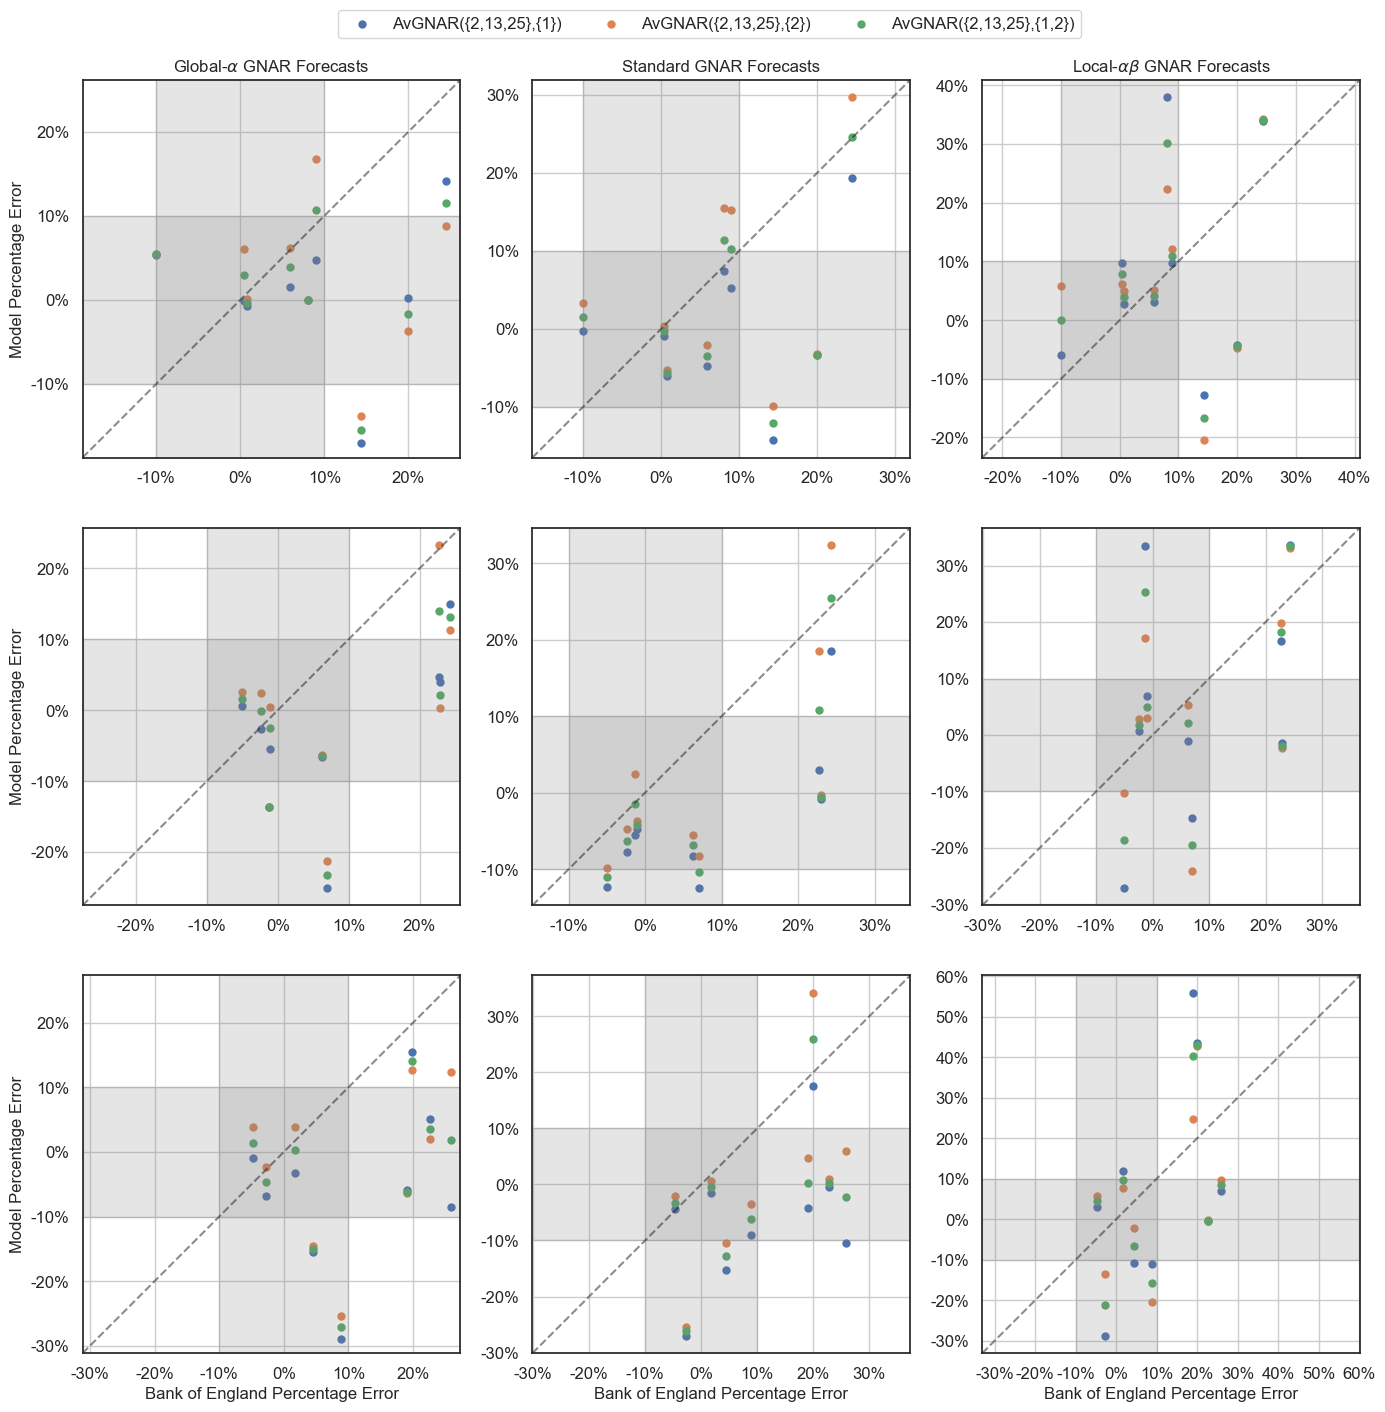

In [192]:
fig,axes = plt.subplots(3, 3, figsize=(14,14))
lines = bank_scatter(avgnar_glo_5, [avgnar_models[i] for i in [1,3,5]], 4, ax=axes[0,0])
lines = bank_scatter(avgnar_std_5, [avgnar_models[i] for i in [1,3,5]], 4, ax=axes[0,1])
lines = bank_scatter(avgnar_loc_5, [avgnar_models[i] for i in [1,3,5]], 4, ax=axes[0,2])

lines = bank_scatter(avgnar_glo_5, [avgnar_models[i] for i in [1,3,5]], 5, ax=axes[1,0])
lines = bank_scatter(avgnar_std_5, [avgnar_models[i] for i in [1,3,5]], 5, ax=axes[1,1])
lines = bank_scatter(avgnar_loc_5, [avgnar_models[i] for i in [1,3,5]], 5, ax=axes[1,2])

lines = bank_scatter(avgnar_glo_5, [avgnar_models[i] for i in [1,3,5]], 6, ax=axes[2,0])
lines = bank_scatter(avgnar_std_5, [avgnar_models[i] for i in [1,3,5]], 6, ax=axes[2,1])
lines = bank_scatter(avgnar_loc_5, [avgnar_models[i] for i in [1,3,5]], 6, ax=axes[2,2])

for i in [0,1,2]:
    for j in [0,1,2]:
        if i < 2:
            axes[i,j].set_xlabel("")
        if j > 0:
            axes[i,j].set_ylabel("")

axes[0,0].set_title(r"Global-$\alpha$ GNAR Forecasts")
axes[0,1].set_title(r"Standard GNAR Forecasts")
axes[0,2].set_title(r"Local-$\alpha\beta$ GNAR Forecasts")
fig.legend(handles=lines, loc='upper center', ncol=6, bbox_to_anchor=(0.512, 1.02), fontsize=12)

plt.tight_layout()
plt.savefig("figures/percentage_error.png", format="png", dpi=300, bbox_inches='tight')

### Relative to Benchmark RMSEs

This final section presents the RMSEs relative to the AR({2,13,25}) benchmark. 

In [185]:
avar = pd.read_csv("results/benchmarks/avar_forecasts.csv", index_col=0, header=[0,1])
avar.index = pd.to_datetime(avar.index)
benchmark = avar[["AvAR({2,13,25})"]]
# Replace columns, since the forecast horizon column headers have been loaded as stings
benchmark.columns = pd.MultiIndex.from_product([["AvAR({2,13,25})"], range(1, 13)])
benchmark_rmse = compute_rmse_df(benchmark).to_numpy().flatten()

Forecasts using only the best network each month. Table 2.

In [187]:
np.round(pd.concat([compute_rmse_df(bic_glo_1).T, compute_rmse_df(bic_std_1).T, 
                    compute_rmse_df(bic_loc_1).T], keys=["Global", "Standard", "Local"]) / benchmark_rmse, 2)

1     2     3     4     5     6     7     8     9   \
Global   GNAR(p,1)  1.03  1.03  1.02  1.00  0.98  0.99  0.98  0.97  0.96   
         GNAR(p,2)  1.05  1.02  1.02  1.02  1.01  1.03  1.03  1.02  1.03   
         GNAR(p,s)  1.05  1.03  1.03  1.03  1.02  1.04  1.03  1.03  1.03   
Standard GNAR(p,1)  1.09  1.09  1.06  1.02  0.99  0.99  0.99  1.00  1.00   
         GNAR(p,2)  1.05  1.03  1.03  0.99  0.97  0.99  0.97  0.97  0.97   
         GNAR(p,s)  1.06  1.03  1.02  0.98  0.97  0.98  0.97  0.97  0.98   
Local    GNAR(p,1)  1.05  1.01  0.95  0.90  0.87  0.86  0.86  0.87  0.88   
         GNAR(p,2)  1.00  0.94  0.89  0.83  0.81  0.82  0.81  0.82  0.84   
         GNAR(p,s)  1.01  0.95  0.89  0.82  0.81  0.81  0.81  0.82  0.84   

                      10    11    12  
Global   GNAR(p,1)  0.96  0.94  0.92  
         GNAR(p,2)  1.03  1.02  1.01  
         GNAR(p,s)  1.03  1.03  1.01  
Standard GNAR(p,1)  0.99  0.98  0.98  
         GNAR(p,2)  0.97  0.96  0.96  
         GNAR(p,s)  0.97  0.96  0.97  
Local    GNAR(p,1)  0.88  0.88  0.88  
         GNAR(p,2)  0.85  0.85  0.86  
         GNAR(p,s)  0.85  0.86  0.87

Forecasts computed by averaging across the 5 best networks each month. Part of Table 4.

In [188]:
np.round(pd.concat([compute_rmse_df(bic_glo_5).T, compute_rmse_df(bic_std_5).T, 
                    compute_rmse_df(bic_loc_5).T], keys=["Global", "Standard", "Local"]) / benchmark_rmse, 2)

1     2     3     4     5     6     7     8     9   \
Global   GNAR(p,1)  1.01  0.99  0.98  0.96  0.94  0.95  0.94  0.94  0.94   
         GNAR(p,2)  1.00  0.98  0.98  0.97  0.97  0.98  0.98  0.98  0.99   
         GNAR(p,s)  1.02  1.00  0.99  0.99  0.98  1.00  0.99  0.99  1.00   
Standard GNAR(p,1)  1.05  1.02  0.98  0.94  0.92  0.92  0.91  0.92  0.93   
         GNAR(p,2)  1.00  0.97  0.95  0.92  0.92  0.93  0.92  0.93  0.94   
         GNAR(p,s)  1.01  0.98  0.95  0.93  0.93  0.94  0.93  0.94  0.95   
Local    GNAR(p,1)  1.02  0.98  0.92  0.87  0.84  0.83  0.83  0.84  0.85   
         GNAR(p,2)  0.96  0.92  0.88  0.82  0.79  0.80  0.79  0.79  0.81   
         GNAR(p,s)  0.98  0.93  0.88  0.82  0.79  0.79  0.79  0.79  0.80   

                      10    11    12  
Global   GNAR(p,1)  0.94  0.93  0.91  
         GNAR(p,2)  1.00  0.99  0.98  
         GNAR(p,s)  1.00  1.00  0.99  
Standard GNAR(p,1)  0.92  0.92  0.92  
         GNAR(p,2)  0.95  0.95  0.95  
         GNAR(p,s)  0.96  0.96  0.96  
Local    GNAR(p,1)  0.85  0.85  0.85  
         GNAR(p,2)  0.81  0.81  0.81  
         GNAR(p,s)  0.81  0.80  0.81

Forecasts using only the best network each month. Table 3.

In [189]:
np.round(pd.concat([compute_rmse_df(avgnar_glo_1).T, compute_rmse_df(avgnar_std_1).T, 
                    compute_rmse_df(avgnar_loc_1).T], keys=["Global", "Standard", "Local"]) / benchmark_rmse, 2)

1     2     3     4     5     6     7   \
Global   AvGNAR({1,13,25},{1})    0.96  0.95  0.96  0.93  0.90  0.91  0.91   
         AvGNAR({2,13,25},{1})    0.96  0.95  0.95  0.91  0.89  0.90  0.89   
         AvGNAR({1,13,25},{2})    0.92  0.95  0.94  0.90  0.89  0.89  0.88   
         AvGNAR({2,13,25},{2})    0.92  0.94  0.93  0.89  0.87  0.88  0.86   
         AvGNAR({1,13,25},{1,2})  0.92  0.94  0.94  0.90  0.89  0.89  0.89   
         AvGNAR({2,13,25},{1,2})  0.92  0.93  0.93  0.89  0.87  0.88  0.87   
Standard AvGNAR({1,13,25},{1})    0.94  0.94  0.93  0.91  0.89  0.89  0.89   
         AvGNAR({2,13,25},{1})    0.94  0.93  0.92  0.90  0.88  0.89  0.88   
         AvGNAR({1,13,25},{2})    0.92  0.93  0.92  0.89  0.88  0.89  0.88   
         AvGNAR({2,13,25},{2})    0.91  0.92  0.90  0.87  0.86  0.88  0.87   
         AvGNAR({1,13,25},{1,2})  0.92  0.93  0.91  0.89  0.88  0.89  0.88   
         AvGNAR({2,13,25},{1,2})  0.92  0.92  0.90  0.88  0.87  0.88  0.87   
Local    AvGNAR({1,13,25},{1})    0.90  0.93  0.91  0.89  0.87  0.87  0.87   
         AvGNAR({2,13,25},{1})    0.90  0.93  0.92  0.90  0.88  0.89  0.89   
         AvGNAR({1,13,25},{2})    0.90  0.95  0.89  0.84  0.81  0.82  0.84   
         AvGNAR({2,13,25},{2})    0.90  0.97  0.91  0.87  0.84  0.85  0.86   
         AvGNAR({1,13,25},{1,2})  0.88  0.91  0.87  0.84  0.82  0.82  0.83   
         AvGNAR({2,13,25},{1,2})  0.87  0.93  0.89  0.86  0.84  0.85  0.85   

                                    8     9     10    11    12  
Global   AvGNAR({1,13,25},{1})    0.90  0.90  0.91  0.91  0.90  
         AvGNAR({2,13,25},{1})    0.89  0.89  0.90  0.90  0.90  
         AvGNAR({1,13,25},{2})    0.88  0.89  0.90  0.90  0.91  
         AvGNAR({2,13,25},{2})    0.86  0.87  0.89  0.89  0.90  
         AvGNAR({1,13,25},{1,2})  0.88  0.89  0.90  0.90  0.90  
         AvGNAR({2,13,25},{1,2})  0.87  0.88  0.89  0.89  0.89  
Standard AvGNAR({1,13,25},{1})    0.89  0.90  0.91  0.91  0.91  
         AvGNAR({2,13,25},{1})    0.88  0.89  0.90  0.90  0.90  
         AvGNAR({1,13,25},{2})    0.87  0.87  0.89  0.89  0.89  
         AvGNAR({2,13,25},{2})    0.87  0.87  0.89  0.89  0.90  
         AvGNAR({1,13,25},{1,2})  0.88  0.88  0.89  0.89  0.90  
         AvGNAR({2,13,25},{1,2})  0.87  0.88  0.89  0.89  0.89  
Local    AvGNAR({1,13,25},{1})    0.87  0.88  0.89  0.89  0.89  
         AvGNAR({2,13,25},{1})    0.89  0.89  0.90  0.90  0.90  
         AvGNAR({1,13,25},{2})    0.85  0.87  0.88  0.89  0.91  
         AvGNAR({2,13,25},{2})    0.87  0.89  0.91  0.91  0.93  
         AvGNAR({1,13,25},{1,2})  0.84  0.85  0.86  0.87  0.88  
         AvGNAR({2,13,25},{1,2})  0.86  0.87  0.88  0.88  0.89

Forecasts computed by averaging across the 5 best networks each month. Part of Table 4.

In [190]:
np.round(pd.concat([compute_rmse_df(avgnar_glo_5).T, compute_rmse_df(avgnar_std_5).T, 
                    compute_rmse_df(avgnar_loc_5).T], keys=["Global", "Standard", "Local"]) / benchmark_rmse, 2)

1     2     3     4     5     6     7   \
Global   AvGNAR({1,13,25},{1})    0.94  0.94  0.94  0.91  0.89  0.90  0.90   
         AvGNAR({2,13,25},{1})    0.93  0.94  0.93  0.90  0.88  0.89  0.89   
         AvGNAR({1,13,25},{2})    0.89  0.88  0.87  0.84  0.82  0.83  0.83   
         AvGNAR({2,13,25},{2})    0.89  0.89  0.88  0.85  0.83  0.83  0.83   
         AvGNAR({1,13,25},{1,2})  0.91  0.91  0.90  0.87  0.85  0.86  0.86   
         AvGNAR({2,13,25},{1,2})  0.91  0.91  0.90  0.87  0.85  0.86  0.86   
Standard AvGNAR({1,13,25},{1})    0.94  0.93  0.91  0.88  0.87  0.87  0.87   
         AvGNAR({2,13,25},{1})    0.94  0.93  0.91  0.89  0.87  0.87  0.87   
         AvGNAR({1,13,25},{2})    0.92  0.91  0.90  0.87  0.86  0.87  0.86   
         AvGNAR({2,13,25},{2})    0.92  0.92  0.90  0.88  0.86  0.87  0.87   
         AvGNAR({1,13,25},{1,2})  0.93  0.92  0.90  0.88  0.86  0.86  0.86   
         AvGNAR({2,13,25},{1,2})  0.93  0.92  0.90  0.88  0.86  0.87  0.87   
Local    AvGNAR({1,13,25},{1})    0.86  0.87  0.85  0.83  0.81  0.82  0.82   
         AvGNAR({2,13,25},{1})    0.85  0.88  0.87  0.85  0.83  0.84  0.84   
         AvGNAR({1,13,25},{2})    0.83  0.86  0.83  0.81  0.80  0.80  0.81   
         AvGNAR({2,13,25},{2})    0.83  0.87  0.85  0.84  0.82  0.83  0.83   
         AvGNAR({1,13,25},{1,2})  0.84  0.86  0.84  0.82  0.80  0.80  0.81   
         AvGNAR({2,13,25},{1,2})  0.83  0.87  0.85  0.84  0.82  0.83  0.83   

                                    8     9     10    11    12  
Global   AvGNAR({1,13,25},{1})    0.90  0.90  0.91  0.91  0.90  
         AvGNAR({2,13,25},{1})    0.89  0.89  0.90  0.90  0.90  
         AvGNAR({1,13,25},{2})    0.84  0.85  0.86  0.87  0.87  
         AvGNAR({2,13,25},{2})    0.84  0.85  0.86  0.87  0.87  
         AvGNAR({1,13,25},{1,2})  0.87  0.87  0.88  0.88  0.88  
         AvGNAR({2,13,25},{1,2})  0.86  0.87  0.88  0.88  0.88  
Standard AvGNAR({1,13,25},{1})    0.87  0.87  0.88  0.88  0.88  
         AvGNAR({2,13,25},{1})    0.87  0.87  0.88  0.88  0.88  
         AvGNAR({1,13,25},{2})    0.86  0.87  0.88  0.89  0.89  
         AvGNAR({2,13,25},{2})    0.87  0.88  0.89  0.89  0.89  
         AvGNAR({1,13,25},{1,2})  0.86  0.87  0.88  0.88  0.88  
         AvGNAR({2,13,25},{1,2})  0.87  0.87  0.88  0.88  0.89  
Local    AvGNAR({1,13,25},{1})    0.82  0.83  0.84  0.85  0.86  
         AvGNAR({2,13,25},{1})    0.84  0.85  0.87  0.87  0.87  
         AvGNAR({1,13,25},{2})    0.82  0.83  0.84  0.84  0.85  
         AvGNAR({2,13,25},{2})    0.84  0.85  0.86  0.86  0.87  
         AvGNAR({1,13,25},{1,2})  0.82  0.82  0.84  0.84  0.85  
         AvGNAR({2,13,25},{1,2})  0.84  0.85  0.86  0.86  0.87